In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np

# Ensure reproducibility
torch.manual_seed(1)
np.random.seed(1)

0.0001801


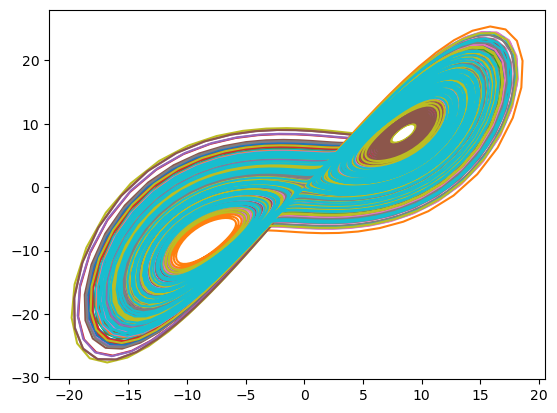

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
print(model.dt)
# model.dt = 0.01
# ## Solve for multiple initial conditions
model.ic = model.ic[None, :] * np.random.random(20)[:, None]


sol = model.make_trajectory(3000, resample=True)
plt.figure()
plt.plot(sol[..., 0].T, sol[..., 1].T);

In [3]:
sol.shape

(20, 3000, 3)

In [25]:
#construct delay embedding
x = sol[:, :,0]

n_delays = 20
delay_interval = 1

# create delay embedding
H = np.array(
    [
        x[:,i : i + n_delays * delay_interval : delay_interval]
        for i in range(x.shape[1] - n_delays * delay_interval)
    ]
).transpose(1, 0, 2)

H.shape

(20, 2980, 20)

[0.84828561 0.98100813 0.99809946 0.99981004 0.99998181 0.99999823
 0.99999983 0.99999998 1.         1.        ]
1.3559343768308603


Text(0.5, 1.0, '20 delay embedding')

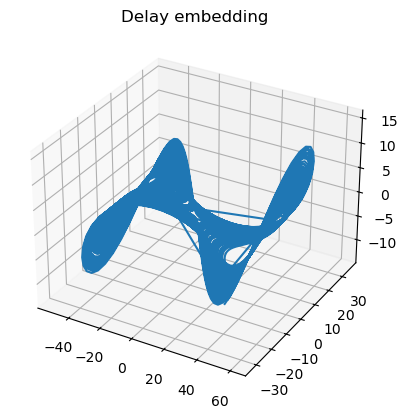

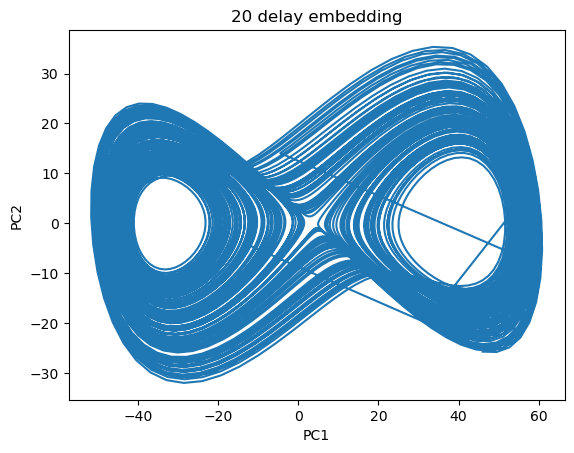

In [26]:
#visualize top 2 pcs
# plot top 3 dimensions of the delay embedding after PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
H_red = pca.fit_transform(H.reshape(-1, H.shape[-1]))


# plot in 3d
plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(H_red[:10000, 0], H_red[:10000, 1], H_red[:10000, 2])
plt.title("Delay embedding")

print(np.cumsum(pca.explained_variance_ratio_))
#print participation ratio
print(np.sum(pca.explained_variance_ratio_)**2 / np.sum(pca.explained_variance_ratio_**2))


#plot top 2 as well
plt.figure()
plt.plot(H_red[:10000, 0], H_red[:10000, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"{n_delays} delay embedding")

In [6]:
class Sampling(nn.Module):
    """Uses (z_mean, z_log_var) to sample z, based on reparameterization trick."""
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.size()
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * 0.1 * epsilon

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim,nonlin=nn.Tanh()):
        super(Encoder, self).__init__()
        self.dense1 = nn.Linear(input_dim, latent_dim, bias=True)
        self.nonlin = nonlin
        # self.dense2 = nn.Linear(2*latent_dim, latent_dim, bias=True)
        self.z_mean = nn.Linear(latent_dim, latent_dim, bias=True)
        self.z_log_var = nn.Linear(latent_dim, latent_dim, bias=True)
        self.sampling = Sampling()

    def forward(self, x):
        x = self.nonlin(self.dense1(x))
        # x = self.nonlin(self.dense2(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim,nonlin=nn.Tanh()):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, hidden_dim, bias=True)
        self.nonlin = nonlin
        self.dense2 = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, z):
        z = self.nonlin(self.dense1(z))
        return self.dense2(z)

class VAE(nn.Module):
    def __init__(self, encoder, decoder, beta=0.1, anneal_step=1000):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.anneal_step = anneal_step

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def loss_function(self, recon_x, x, z_mean, z_log_var, iteration):
        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
        # KL loss
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
        # Annealing factor
        kl_anneal = self.beta * min(1.0, iteration / self.anneal_step)
        return recon_loss + kl_anneal * kl_loss,recon_loss,kl_loss

In [27]:
xtrain, ytrain = H_red.reshape(-1,H_red.shape[-1]), H_red.reshape(-1,H_red.shape[-1])
#rotate into the SVD V.T space

#standard scale them too
xtrain = (xtrain - xtrain.mean(axis=0)) / xtrain.std(axis=0)
ytrain = (ytrain - ytrain.mean(axis=0)) / ytrain.std(axis=0)
xtrain.shape,ytrain.shape

((59600, 10), (59600, 10))

In [28]:
# Instantiate and prepare training
input_dim = xtrain.shape[1]
output_dim = ytrain.shape[1]
latent_dim = 5
hidden_dim = 100
encoder = Encoder(input_dim,latent_dim)
decoder = Decoder(latent_dim, hidden_dim,output_dim)
vae = VAE(encoder, decoder,beta=0.001,anneal_step=1000)
optimizer = optim.AdamW(vae.parameters(), lr=0.01,weight_decay=0.01)

# Training loop
def train(model, data_loader, epochs=1000):
    model.train()
    for epoch in range(epochs):
        for iteration, (data1, data2) in enumerate(data_loader):
            optimizer.zero_grad()
            reconstruction, z_mean, z_log_var = model(data1)
            loss,recon,kl = model.loss_function(reconstruction, data2, z_mean, z_log_var, epoch)
            loss.backward()
            optimizer.step()
            print(f"Epoch [{epoch+1}/{epochs}], reconstruction loss: {recon.item():.4f}, KL loss: {kl.item():.4f}")

# Data loading and training
dataset = TensorDataset(torch.tensor(xtrain, dtype=torch.float), torch.tensor(ytrain, dtype=torch.float))
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True)
train(vae, data_loader)

# Evaluate
vae.eval()
with torch.no_grad():
    predictions = vae(torch.tensor(xtrain, dtype=torch.float))[0]
    r_squared = r2_score(ytrain, predictions.numpy(), multioutput='variance_weighted')

print("R-squared:", r_squared)

Epoch [1/1000], reconstruction loss: 1.0751, KL loss: 509.0230
Epoch [1/1000], reconstruction loss: 0.9628, KL loss: 502.8566
Epoch [1/1000], reconstruction loss: 0.8184, KL loss: 473.8105
Epoch [1/1000], reconstruction loss: 0.8682, KL loss: 495.7207
Epoch [1/1000], reconstruction loss: 0.8334, KL loss: 531.6381
Epoch [1/1000], reconstruction loss: 0.7776, KL loss: 547.8953
Epoch [1/1000], reconstruction loss: 0.7330, KL loss: 568.9297
Epoch [1/1000], reconstruction loss: 0.6902, KL loss: 568.3479
Epoch [1/1000], reconstruction loss: 0.7470, KL loss: 585.1788
Epoch [1/1000], reconstruction loss: 0.6304, KL loss: 570.4238
Epoch [1/1000], reconstruction loss: 0.7244, KL loss: 582.1663
Epoch [1/1000], reconstruction loss: 0.7386, KL loss: 573.6875
Epoch [1/1000], reconstruction loss: 0.7169, KL loss: 578.8071
Epoch [1/1000], reconstruction loss: 0.6910, KL loss: 574.0365
Epoch [1/1000], reconstruction loss: 0.7016, KL loss: 573.8204
Epoch [1/1000], reconstruction loss: 0.7162, KL loss: 6

(20, 3000, 3)


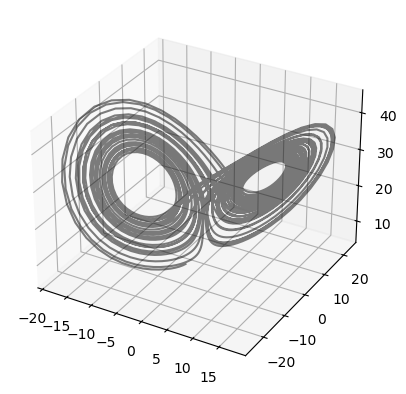

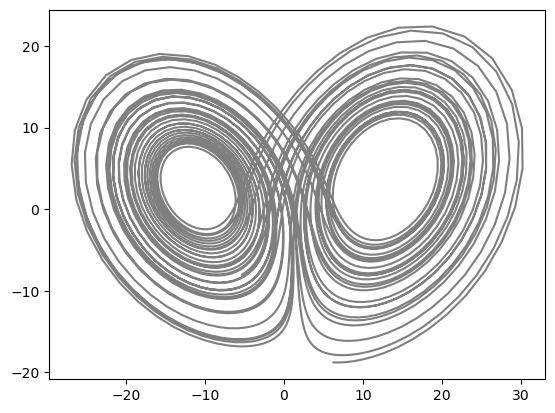

In [19]:
val = sol[0,:10000]
print(sol.shape)
plt.figure()
#plot in 3d
ax = plt.axes(projection="3d")
ax.plot3D(val[:10000, 0], val[:10000, 1], val[:10000, 2],c="k",alpha=0.5)

#do PCa and plot top 2
pca = PCA(n_components=2)
val_red = pca.fit_transform(val)
plt.figure()
plt.plot(val_red[:10000, 0], val_red[:10000, 1],c="k",alpha=0.5)


(20, 2900, 3)


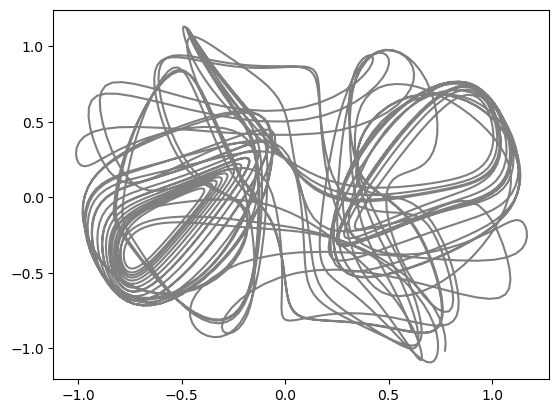

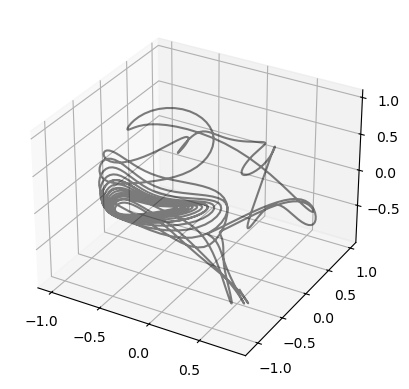

In [20]:
#visualize latent dynamics

z = vae.encoder(torch.tensor(xtrain, dtype=torch.float))[0].detach().numpy()
#reshape into 20 x 3000-n_delays*delay_interval x latent_dim
z = z.reshape(H.shape[0],-1,latent_dim)
#do a pca to 3 dimensions
pca = PCA(n_components=3)
z = pca.fit_transform(z.reshape(-1, z.shape[-1]))
z = z.reshape(H.shape[0],-1,3)
print(z.shape)

plt.plot(z[0,:10000, 0], z[0,:10000, 1],c="k",alpha=0.5)
if z.shape[-1] >= 3:
    plt.figure()
    #plot in 3d
    ax = plt.axes(projection="3d")
    ax.plot3D(z[0,:1000, 0], z[0,:1000, 1], z[0,:1000, 2],c="k",alpha=0.5)
